<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#MNIST-Dataset" data-toc-modified-id="MNIST-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Get-the-MNIST-data" data-toc-modified-id="Get-the-MNIST-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get the MNIST data</a></span></li><li><span><a href="#MLP-in-TensorFlow" data-toc-modified-id="MLP-in-TensorFlow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>MLP in TensorFlow</a></span></li><li><span><a href="#MLP-in-Keras" data-toc-modified-id="MLP-in-Keras-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>MLP in Keras</a></span></li><li><span><a href="#MLP-in-TFLearn" data-toc-modified-id="MLP-in-TFLearn-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>MLP in TFLearn</a></span></li></ul></li><li><span><a href="#TimeSeries-Data---MLP---Keras" data-toc-modified-id="TimeSeries-Data---MLP---Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TimeSeries Data - MLP - Keras</a></span><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prepare the data</a></span></li><li><span><a href="#Build,-Train-and-Evaluate-the-Model" data-toc-modified-id="Build,-Train-and-Evaluate-the-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build, Train and Evaluate the Model</a></span></li></ul></li></ul></div>

# MultiLayer Perceptron <a class="tocSkip">

In [54]:
import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import math
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = [15, 10]
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.15.4
Pandas:0.24.0
Matplotlib:3.0.2
TensorFlow:1.12.0
Keras:2.2.4


In [2]:
# DATASETSLIB_HOME = '../datasetslib'
# import sys
# if not DATASETSLIB_HOME in sys.path:
#     sys.path.append(DATASETSLIB_HOME)
# %reload_ext autoreload
# %autoreload 2
# import datasetslib

# from datasetslib import util as dsu

In [3]:
# datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# MNIST Dataset

## Get the MNIST data

In [4]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets(os.path.join(datasetslib.datasets_root, 'mnist'),
#                                   one_hot=True)

# X_train = mnist.train.images
# X_test = mnist.test.images
# Y_train = mnist.train.labels
# Y_test = mnist.test.labels

# num_outputs = 10  # 0-9 digits
# num_inputs = 784  # total pixels

In [2]:
# import the keras modules
from keras.datasets import mnist

# define some hyper parameters
num_inputs = 784
num_outputs = 10

# get the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape the two dimensional 28 x 28 pixels
#   sized images into a single vector of 784 pixels
X_train = X_train.reshape(60000, num_inputs)
X_test = X_test.reshape(10000, num_inputs)

# convert the input values to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# normalize the values of image vectors to fit under 1
X_train /= 255
X_test /= 255

In [3]:
X_train.shape

(60000, 784)

In [4]:
# convert output data into one hot encoded format
Y_train = keras.utils.to_categorical(Y_train, num_outputs)
Y_test = keras.utils.to_categorical(Y_test, num_outputs)

In [5]:
print(Y_train.shape)
print(Y_test.shape)

(60000, 10)
(10000, 10)


## MLP in TensorFlow

In [6]:
tf.reset_default_graph()

In [7]:
def mlp(x, num_inputs, num_outputs, num_layers, num_neurons):
    w = []
    b = []
    for i in range(num_layers):
        # weights
        w.append(tf.Variable(tf.random_normal(
            [num_inputs if i == 0 else num_neurons[i - 1],
             num_neurons[i]]),
            name="w_{0:04d}".format(i)
        ))
        # biases
        b.append(tf.Variable(tf.random_normal(
            [num_neurons[i]]),
            name="b_{0:04d}".format(i)
        ))
    w.append(tf.Variable(tf.random_normal(
        [num_neurons[num_layers - 1] if num_layers > 0 else num_inputs,
         num_outputs]), name="w_out"))
    b.append(tf.Variable(tf.random_normal([num_outputs]), name="b_out"))

    # x is input layer
    layer = x
    # add hidden layers
    for i in range(num_layers):
        layer = tf.nn.relu(tf.matmul(layer, w[i]) + b[i])
    # add output layer
    layer = tf.matmul(layer, w[num_layers]) + b[num_layers]

    return layer


# def mnist_batch_func(batch_size=100):
#     X_batch, Y_batch = mnist.train.next_batch(batch_size)
#     return [X_batch, Y_batch]

def mnist_batch_func(X = X_train, Y = Y_train, batch_size=100):
    
    n_batches = X.shape[0] / batch_size
    
    X_batch_list = np.array_split(X, n_batches)
    Y_batch_list = np.array_split(Y, n_batches)
    
#     X_batch, Y_batch = mnist.train.next_batch(batch_size)
    return [X_batch_list, Y_batch_list]


def tensorflow_classification(n_epochs, n_batches,
                              batch_size, batch_func,
                              model, optimizer, loss, accuracy_function,
                              X_test, Y_test):
    with tf.Session() as tfs:
        tfs.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            X_batch_list, Y_batch_list = mnist_batch_func(batch_size = batch_size)
            for batch in range(n_batches):
                X_batch, Y_batch = X_batch_list[batch], Y_batch_list[batch]
                feed_dict = {x: X_batch, y: Y_batch}
                _, batch_loss = tfs.run([optimizer, loss], feed_dict)
                epoch_loss += batch_loss
            average_loss = epoch_loss / n_batches
            print("epoch: {0:04d}   loss = {1:0.6f}".format(
                epoch, average_loss))
        feed_dict = {x: X_test, y: Y_test}
        accuracy_score = tfs.run(accuracy_function, feed_dict=feed_dict)
        print("accuracy={0:.8f}".format(accuracy_score))

In [11]:
# X, Y = mnist_batch_func()

In [12]:
# output length of each batch to make sure it makes sense
# for i in range(len(X)):
#     print((X[i].shape[0], Y[i].shape[0]), '\n')

In [12]:
# example of the tf.random_normal function

x = tf.random_normal([4, 5])
print(x)

with tf.Session() as tfs:
    # initialize and print the variable y
    tf.global_variables_initializer().run()
    output = tfs.run(tf.random_normal([4, 5]))
print('output :\n', output)

Tensor("random_normal_2:0", shape=(4, 5), dtype=float32)
output :
 [[ 1.4308443   0.21598655  0.16742042  0.32844824  0.81895316]
 [-0.5336164   0.91035134 -0.18558274 -0.386445    0.62272984]
 [-0.6453689  -0.67798245 -1.4613935  -0.79655427 -1.7472252 ]
 [-0.35917163  0.5903824  -0.4428815   1.045207    0.3916905 ]]


In [14]:
tf.reset_default_graph()

In [14]:
num_layers = 0
num_neurons = []
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(X_train.shape[0] / batch_size)#int(mnist.train.num_examples / batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs])
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs])

model = mlp(x=x,
            num_inputs=num_inputs,
            num_outputs=num_outputs,
            num_layers=num_layers,
            num_neurons=num_neurons)

# loss function
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=y))
# optimizer function
optimizer = tf.train.AdamOptimizer( # try with adam optimizer instead of cross entropy. accuracy was about 86% with cross ent
    learning_rate=learning_rate).minimize(loss)

predictions_check = tf.equal(tf.argmax(model, 1), tf.argmax(y, 1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs,
                          n_batches=n_batches,
                          batch_size=batch_size,
                          batch_func=mnist_batch_func,
                          model=model,
                          optimizer=optimizer,
                          loss=loss,
                          accuracy_function=accuracy_function,
                          X_test=X_test,
                          Y_test=Y_test
                          )

epoch: 0000   loss = 1.478018
epoch: 0001   loss = 0.520986
epoch: 0002   loss = 0.432759
epoch: 0003   loss = 0.391442
epoch: 0004   loss = 0.366525
epoch: 0005   loss = 0.349604
epoch: 0006   loss = 0.337375
epoch: 0007   loss = 0.328155
epoch: 0008   loss = 0.320943
epoch: 0009   loss = 0.315141
epoch: 0010   loss = 0.310383
epoch: 0011   loss = 0.306430
epoch: 0012   loss = 0.303112
epoch: 0013   loss = 0.300300
epoch: 0014   loss = 0.297897
epoch: 0015   loss = 0.295827
epoch: 0016   loss = 0.294025
epoch: 0017   loss = 0.292441
epoch: 0018   loss = 0.291039
epoch: 0019   loss = 0.289791
epoch: 0020   loss = 0.288675
epoch: 0021   loss = 0.287670
epoch: 0022   loss = 0.286760
epoch: 0023   loss = 0.285929
epoch: 0024   loss = 0.285166
epoch: 0025   loss = 0.284463
epoch: 0026   loss = 0.283811
epoch: 0027   loss = 0.283206
epoch: 0028   loss = 0.282643
epoch: 0029   loss = 0.282118
epoch: 0030   loss = 0.281627
epoch: 0031   loss = 0.281167
epoch: 0032   loss = 0.280735
epoch: 003

**I've now seen multiple times that the Adam (Spannbauer?) optimizer outperforms SGD and GD**

In [16]:
tf.reset_default_graph()

In [18]:
num_layers = 1 
num_neurons = []
for i in range(num_layers):
    num_neurons.append(8)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(X_train.shape[0] / batch_size)#int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
# optimizer function
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = X_test, 
                          Y_test = Y_test
                         )

epoch: 0000   loss = 4.339280
epoch: 0001   loss = 2.057803
epoch: 0002   loss = 1.889061
epoch: 0003   loss = 1.786949
epoch: 0004   loss = 1.705320
epoch: 0005   loss = 1.633460
epoch: 0006   loss = 1.570390
epoch: 0007   loss = 1.516408
epoch: 0008   loss = 1.470786
epoch: 0009   loss = 1.431555
epoch: 0010   loss = 1.396711
epoch: 0011   loss = 1.365024
epoch: 0012   loss = 1.335094
epoch: 0013   loss = 1.306591
epoch: 0014   loss = 1.279098
epoch: 0015   loss = 1.252181
epoch: 0016   loss = 1.225709
epoch: 0017   loss = 1.199934
epoch: 0018   loss = 1.174942
epoch: 0019   loss = 1.151458
epoch: 0020   loss = 1.129410
epoch: 0021   loss = 1.108514
epoch: 0022   loss = 1.088814
epoch: 0023   loss = 1.070237
epoch: 0024   loss = 1.052308
epoch: 0025   loss = 1.035301
epoch: 0026   loss = 1.019050
epoch: 0027   loss = 1.003461
epoch: 0028   loss = 0.988419
epoch: 0029   loss = 0.974017
epoch: 0030   loss = 0.960182
epoch: 0031   loss = 0.946664
epoch: 0032   loss = 0.933496
epoch: 003

In [15]:
tf.reset_default_graph()

In [16]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100
n_batches = int(X_train.shape[0] / batch_size) # int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, 
                                                              labels=y))
# optimizer function
# try with adam optimizer instead of cross entropy. accuracy was about 92.7% with cross ent
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = X_test, 
                          Y_test = Y_test
                         )

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch: 0000   loss = 44.375139
epoch: 0001   loss = 8.397938
epoch: 0002   loss = 4.509135
epoch: 0003   loss = 2.986160
epoch: 0004   loss = 2.539144
epoch: 0005   loss = 2.141882
epoch: 0006   loss = 1.948118
epoch: 0007   loss = 1.634159
epoch: 0008   loss = 1.445681
epoch: 0009   loss = 1.192475
epoch: 0010   loss = 1.059878
epoch: 0011   loss = 1.150817
epoch: 0012   loss = 1.040099
epoch: 0013   loss = 0.900834
epoch: 0014   loss = 0.766424
epoch: 0015   loss = 0.656884
epoch: 0016   loss = 0.553651
epoch: 0017   loss = 0.586966
epoch: 0018   loss = 0.572291
epoch: 0019   loss = 0.485210
epoch: 0020   loss = 0.476156
epoch: 0021   loss = 0.452883
epoch: 0022   loss = 0.294199
epoch: 0023   loss = 0.325026
epoch: 0024   loss = 0.288851
epoch: 0025   loss = 0.252851
epoch: 0026   loss = 0.19244

**We get 96% accuracy with the Adam optimizer which is a gain of 3.4 percentage points**

In [19]:
tf.reset_default_graph()

In [20]:
num_layers = 5 # Go big or go home, right?
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.02 # Increase the learning rate by .01
n_epochs = 100 # double number of epochs
batch_size = 200 # double batch size
n_batches = int(X_train.shape[0] / batch_size) # int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, 
                                                              labels=y))
# optimizer function
# try with adam optimizer instead of cross entropy. accuracy was about 92.7% with cross ent
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = X_test, 
                          Y_test = Y_test
                         )

epoch: 0000   loss = 56250.010318
epoch: 0001   loss = 2821.987077
epoch: 0002   loss = 1408.689976
epoch: 0003   loss = 897.197176
epoch: 0004   loss = 624.280929
epoch: 0005   loss = 464.055928
epoch: 0006   loss = 393.969788
epoch: 0007   loss = 335.115790
epoch: 0008   loss = 288.773929
epoch: 0009   loss = 264.433701
epoch: 0010   loss = 271.998452
epoch: 0011   loss = 219.789531
epoch: 0012   loss = 207.832373
epoch: 0013   loss = 161.567029
epoch: 0014   loss = 147.672064
epoch: 0015   loss = 140.693812
epoch: 0016   loss = 115.642916
epoch: 0017   loss = 97.511379
epoch: 0018   loss = 73.256253
epoch: 0019   loss = 61.666448
epoch: 0020   loss = 45.256676
epoch: 0021   loss = 31.591079
epoch: 0022   loss = 28.982246
epoch: 0023   loss = 25.749358
epoch: 0024   loss = 20.996418
epoch: 0025   loss = 18.617874
epoch: 0026   loss = 16.405618
epoch: 0027   loss = 6.761414
epoch: 0028   loss = 5.743486
epoch: 0029   loss = 3.215362
epoch: 0030   loss = 2.462707
epoch: 0031   loss = 2

My best accuracy with 5 layers and 256 nuerons/layer was about 12.3%. 

In [21]:
tf.reset_default_graph()

In [22]:
num_layers = 3 
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.02 # Increase the learning rate by .01
n_epochs = 100 # double number of epochs
batch_size = 200 # double batch size
n_batches = int(X_train.shape[0] / batch_size) # int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, 
                                                              labels=y))
# optimizer function
# try with adam optimizer instead of cross entropy. accuracy was about 92.7% with cross ent
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = X_test, 
                          Y_test = Y_test
                         )

epoch: 0000   loss = 461.545876
epoch: 0001   loss = 51.363295
epoch: 0002   loss = 25.869704
epoch: 0003   loss = 17.438965
epoch: 0004   loss = 12.721127
epoch: 0005   loss = 10.786955
epoch: 0006   loss = 10.033877
epoch: 0007   loss = 7.427215
epoch: 0008   loss = 7.108135
epoch: 0009   loss = 6.228600
epoch: 0010   loss = 5.539004
epoch: 0011   loss = 5.009918
epoch: 0012   loss = 4.356726
epoch: 0013   loss = 3.273103
epoch: 0014   loss = 2.497285
epoch: 0015   loss = 2.107906
epoch: 0016   loss = 1.742026
epoch: 0017   loss = 1.289117
epoch: 0018   loss = 1.545825
epoch: 0019   loss = 0.624611
epoch: 0020   loss = 0.303086
epoch: 0021   loss = 0.341541
epoch: 0022   loss = 0.430074
epoch: 0023   loss = 0.312875
epoch: 0024   loss = 0.236133
epoch: 0025   loss = 0.271017
epoch: 0026   loss = 0.300903
epoch: 0027   loss = 0.273093
epoch: 0028   loss = 0.311134
epoch: 0029   loss = 0.318699
epoch: 0030   loss = 0.293321
epoch: 0031   loss = 0.271325
epoch: 0032   loss = 0.428915
ep

With 3 layers (256 units/layer), our lowest loss came on epoch 31 (lr = .02). The ending accuracy was 10.2%. What happens if we decrease the learning rate by quite a bit and increase the number of epochs?

In [25]:
tf.reset_default_graph()

num_layers = 3 
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.001 # decrease learning rate
n_epochs = 100 # double number of epochs
batch_size = 200 # double batch size
n_batches = int(X_train.shape[0] / batch_size) # int(mnist.train.num_examples/batch_size)

# input images
x = tf.placeholder(dtype=tf.float32, name="x", shape=[None, num_inputs]) 
# target output
y = tf.placeholder(dtype=tf.float32, name="y", shape=[None, num_outputs]) 

model = mlp(x=x, 
            num_inputs=num_inputs, 
            num_outputs=num_outputs, 
            num_layers=num_layers, 
            num_neurons=num_neurons)

# loss function
#loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(model), axis=1))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, 
                                                              labels=y))
# optimizer function
# try with adam optimizer instead of cross entropy. accuracy was about 92.7% with cross ent
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

predictions_check = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy_function = tf.reduce_mean(tf.cast(predictions_check, tf.float32))

tensorflow_classification(n_epochs=n_epochs, 
                          n_batches=n_batches, 
                          batch_size=batch_size, 
                          batch_func=mnist_batch_func, 
                          model = model, 
                          optimizer = optimizer, 
                          loss = loss, 
                          accuracy_function = accuracy_function, 
                          X_test = X_test, 
                          Y_test = Y_test
                         )

epoch: 0000   loss = 2090.058461
epoch: 0001   loss = 500.446410
epoch: 0002   loss = 317.122395
epoch: 0003   loss = 226.947661
epoch: 0004   loss = 169.058215
epoch: 0005   loss = 130.501939
epoch: 0006   loss = 101.134609
epoch: 0007   loss = 78.951365
epoch: 0008   loss = 61.321995
epoch: 0009   loss = 48.187691
epoch: 0010   loss = 37.959641
epoch: 0011   loss = 30.786289
epoch: 0012   loss = 23.818457
epoch: 0013   loss = 19.612650
epoch: 0014   loss = 15.481491
epoch: 0015   loss = 11.900312
epoch: 0016   loss = 10.691020
epoch: 0017   loss = 8.214411
epoch: 0018   loss = 7.081743
epoch: 0019   loss = 6.355991
epoch: 0020   loss = 5.779816
epoch: 0021   loss = 4.874036
epoch: 0022   loss = 4.570234
epoch: 0023   loss = 4.090625
epoch: 0024   loss = 3.993057
epoch: 0025   loss = 4.004908
epoch: 0026   loss = 3.583505
epoch: 0027   loss = 3.569258
epoch: 0028   loss = 2.956494
epoch: 0029   loss = 3.188025
epoch: 0030   loss = 2.680970
epoch: 0031   loss = 3.240377
epoch: 0032   l

Here we get an accuracy of about 97%, which is an improvement over the 2 layer architecture. It seems that hyperparameters will need to be highly tuned as the model can be very fragile depending on the architecture and parameters. This probably isn't the best out of the box model! 

## MLP in Keras


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [10]:
tf.reset_default_graph()
keras.backend.clear_session()

Use parameters from 3 layer architecture as it seemed to perform slightly better

In [11]:
num_layers = 3
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.001
n_epochs = 70
batch_size = 200

model = Sequential()
model.add(Dense(units=num_neurons[0], activation='relu', 
                input_shape=(num_inputs,)))
model.add(Dense(units=num_neurons[1], activation='relu'))
model.add(Dense(units=num_neurons[2], activation='relu'))
model.add(Dense(units=num_outputs, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=n_epochs)

score = model.evaluate(X_test, Y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
60000/60000 [==============================] - 3s 55us/step - loss: 0.2824 - acc: 0.9194
Epoch 2/70
60000/60000 [==============================] - 1s 24us/step - loss: 0.0986 - acc: 0.9695
Epoch 3/70
60000/60000 [==============================] - 1s 25us/st

It took the model about 45 epochs to figure out the data entirely. Interestingly, It still generalizes pretty well to the data with an accuracy of 98.5%. How does Keras go about picking the model after it trains through many epochs?

## MLP in TFLearn

In [13]:
import tflearn

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [14]:
tf.reset_default_graph()

In [15]:
num_layers = 2
num_neurons = []
for i in range(num_layers):
    num_neurons.append(256)
    
learning_rate = 0.01
n_epochs = 50
batch_size = 100

# Build deep neural network
input_layer = tflearn.input_data(shape=[None, num_inputs])
dense1 = tflearn.fully_connected(input_layer, num_neurons[0], activation='relu')
dense2 = tflearn.fully_connected(dense1, num_neurons[1], activation='relu')
softmax = tflearn.fully_connected(dense2, num_outputs, activation='softmax')

optimizer = tflearn.SGD(learning_rate=learning_rate)
net = tflearn.regression(softmax, optimizer=optimizer, 
                         metric=tflearn.metrics.Accuracy(), 
                         loss='categorical_crossentropy')
model = tflearn.DNN(net)

model.fit(X_train, Y_train, 
          n_epoch=n_epochs, batch_size=batch_size, 
          show_metric=True, run_id='dense_model')

score = model.evaluate(X_test, Y_test)
print('Test accuracy:', score[0])

Training Step: 29999  | total loss: 0.11622 | time: 3.680s
| SGD | epoch: 050 | loss: 0.11622 - acc: 0.9687 -- iter: 59900/60000
Training Step: 30000  | total loss: 0.12170 | time: 3.686s
| SGD | epoch: 050 | loss: 0.12170 - acc: 0.9688 -- iter: 60000/60000
--
Test accuracy: 0.9672


# TimeSeries Data - MLP - Keras

## Prepare the data

In [31]:
import os
import pandas as pd

# dataframe = pd.read_csv(os.path.join(datasetslib.datasets_root, 
#                                      'ts-data', 
#                                      'international-airline-passengers-cleaned.csv'), 
#                         usecols=[1],header=0)

dataset = pd.read_csv("international-airline-passengers.csv")
dataset.columns = ['month', 'passengers']
dataset.set_index(['month'], inplace=True)
# dataset = dataframe.values
# dataset = dataset.astype('float32')

In [32]:
dataset.head()

,passengers
month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [33]:
# normalize the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# dataset.passengers = scaler.fit_transform(dataset.passengers.values.reshape((-1, 1)))

#scaler = skpp.MinMaxScaler(feature_range=(0, 1))
#normalized_dataset = scaler.fit_transform(dataset)

In [34]:
dataset.head()

,passengers
month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


In [35]:
# split into train and test sets
# train,test=dsu.train_test_split(dataset,train_size=0.67)
    
train, test = train_test_split(dataset, test_size=.33, shuffle=False)
print(len(train), len(test))

97 48


In [36]:
# reshape into X=t-1,t and Y=t+1
n_x=2
n_y=1
# X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=n_y)

# train
X_train = pd.concat([train.shift(1), train], axis=1).dropna(axis=0).iloc[:-1, :]
X_train.columns = ['passengers_lag_1', 'passengers']

Y_train = train.shift(-1).iloc[1:, :].dropna(axis=0)

# test
X_test = pd.concat([test.shift(1), test], axis=1).dropna(axis=0).iloc[:-1, :]
X_test.columns = ['passengers_lag_1', 'passengers']

Y_test = test.shift(-1).iloc[1:, :].dropna(axis=0)


In [37]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

95
95
45
45


In [38]:
print(train.head())
print(train.tail())

         passengers
month              
1949-01       112.0
1949-02       118.0
1949-03       132.0
1949-04       129.0
1949-05       121.0
         passengers
month              
1956-09       355.0
1956-10       306.0
1956-11       271.0
1956-12       306.0
1957-01       315.0


In [39]:
print(X_train.head())
print(Y_train.head())
print(X_train.tail())
print(Y_train.tail())

         passengers_lag_1  passengers
month                                
1949-02             112.0       118.0
1949-03             118.0       132.0
1949-04             132.0       129.0
1949-05             129.0       121.0
1949-06             121.0       135.0
         passengers
month              
1949-02       132.0
1949-03       129.0
1949-04       121.0
1949-05       135.0
1949-06       148.0
         passengers_lag_1  passengers
month                                
1956-08             413.0       405.0
1956-09             405.0       355.0
1956-10             355.0       306.0
1956-11             306.0       271.0
1956-12             271.0       306.0
         passengers
month              
1956-08       355.0
1956-09       306.0
1956-10       271.0
1956-11       306.0
1956-12       315.0


In [40]:
X_train.values.shape

(95, 2)

## Build, Train and Evaluate the Model

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [42]:
tf.reset_default_graph()
keras.backend.clear_session()

In [43]:
num_layers = 2
num_neurons = [8,8]
n_epochs = 50
batch_size = 2

model = Sequential()
model.add(Dense(num_neurons[0], activation='relu', input_shape=(n_x,)))
model.add(Dense(num_neurons[1], activation='relu'))
model.add(Dense(units=1))
model.summary()

model.compile(loss='mse', optimizer='adam')

model.fit(X_train.values, Y_train.values,
                    batch_size=batch_size,
                    epochs=n_epochs)

score = model.evaluate(X_test.values, Y_test.values)
print('\nTest mse:', score)
print('Test rmse:', math.sqrt(score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
95/95 [==============================] - 0s 4ms/step - loss: 31530.2103
Epoch 2/50
95/95 [==============================] - 0s 2ms/step - loss: 13188.1121
Epoch 3/50
95/95 [==============================] - 0s 2ms/step - loss: 3814.4853
Epoch 4/50
95/95 [==============================] - 0s 2ms/step - loss: 969.9537
Epoch 5/50
95/95 [==============================] - 0s 2ms/step - loss: 688.169

In [45]:
# make predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [46]:
# shift train predictions for plotting
Y_train_pred_plot = np.empty_like(dataset)
Y_train_pred_plot[:, :] = np.nan
Y_train_pred_plot[n_x-1:len(Y_train_pred)+n_x-1, :] = Y_train_pred

In [52]:
# shift test predictions for plotting
Y_test_pred_plot = np.empty_like(dataset)
Y_test_pred_plot[:, :] = np.nan
Y_test_pred_plot[len(Y_train_pred)+(n_x*2)-1:len(dataset)-2, :] = Y_test_pred

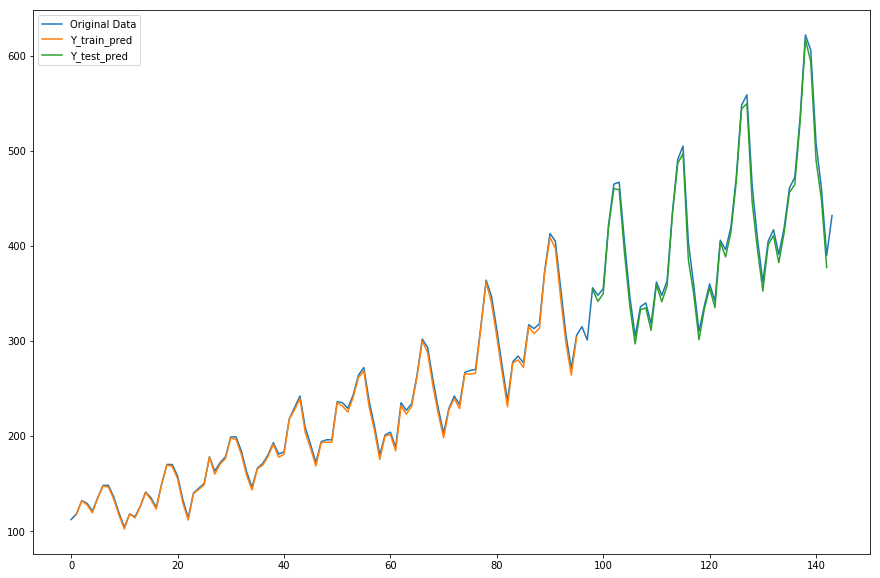

In [57]:
# plot baseline and predictions
plt.plot(dataset.values,label='Original Data')
plt.plot(Y_train_pred_plot,label='Y_train_pred')
plt.plot(Y_test_pred_plot,label='Y_test_pred')
plt.legend()
plt.show()